In [14]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# IMAGE IMPORTS
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
sahi.utils.cv.IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.tif']

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [1]:
pkl = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\48201C0005G.pickle"

In [13]:
len(x)

17

In [20]:
pkl_files

['D:\\RECTDNN\\processing\\2024-10-11_15-08-46\\street_corners\\exp4\\pickles\\\\']

In [39]:
def get_largest_subdirectory(base_dir):
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
    largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
    return os.path.join(base_dir, largest_subdir)

yolo_path = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners"
pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
print(pkldir)

pkl_files = glob.glob(pkldir + "*")

out_dict = {}

for pkl in pkl_files:
    with open(pkl, 'rb') as f:
        x = pickle.load(f)

    out_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])



D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\


54


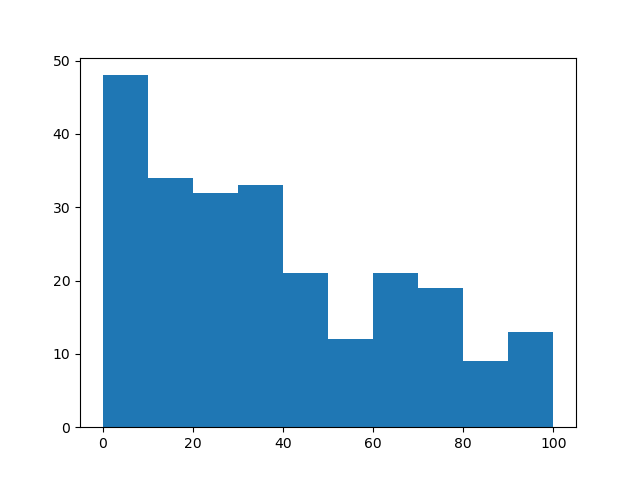

In [42]:
plt.figure()
amount_of_corners = np.array([len(a) for a in out_dict.values()])
_ = plt.hist(amount_of_corners, range=(0, 100))
print(np.count_nonzero(amount_of_corners <= 10))

48


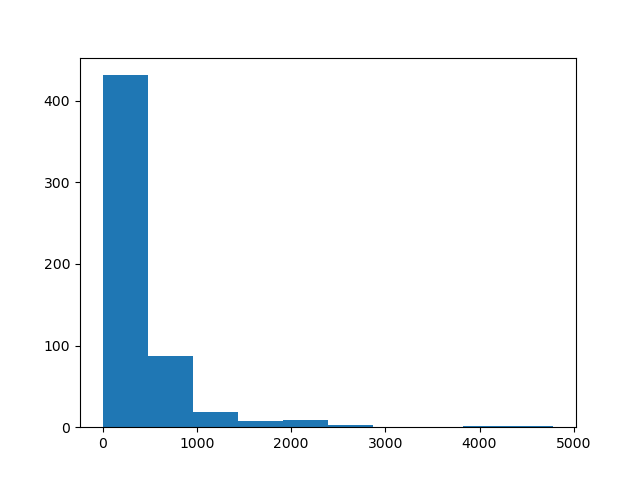